In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.models as models

In [2]:
''' 这里定义了一个数据预处理流程，将图像转换为张量并进行归一化处理,0.1307 和 0.3081 分别是 MNIST 数据集的均值和标准差。'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, num_classes=10):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        # 添加一个线性层将输入维度从 28 转换为 embed_dim
        self.embedding = nn.Linear(28, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # 将输入数据 x 从形状 (batch_size, 1, 28, 28) 重塑为 (batch_size, 28, 28)
        x = x.view(-1, 28, 28)

        # 将输入维度从 28 转换为 embed_dim
        x = self.embedding(x)

        # 调整输入形状以满足 MultiheadAttention 的要求
        x = x.permute(1, 0, 2)  # 调整为 (seq_len, batch_size, embed_dim)

        # 通过多头注意力层
        attn_output, _ = self.attention(x, x, x)

        # 调整输出形状
        attn_output = attn_output.permute(1, 0, 2)  # 调整为 (batch_size, seq_len, embed_dim)

        # 获取最后一个时间步的输出
        out = self.fc(attn_output[:, -1, :])
        return out

In [9]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    return train_loss, train_acc

In [10]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss = running_loss / len(test_loader)
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

In [11]:
# 初始化训练过程中的基本设置和对象
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "MLP": MLP(),
    "ResNet": ResNet(),
    "RNN": RNN(),
    "MultiHeadAttention": MultiHeadAttention()
}

criterion = nn.CrossEntropyLoss()
num_epochs = 10

# 训练和评估函数
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    return train_loss, train_acc

def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss = running_loss / len(test_loader)
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

# 初始化训练过程中的基本设置和对象
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training MLP...
Epoch [1/10], Train Loss: 0.2052, Train Acc: 93.76%, Val Loss: 0.1023
Epoch [2/10], Train Loss: 0.0857, Train Acc: 97.27%, Val Loss: 0.0989
Epoch [3/10], Train Loss: 0.0605, Train Acc: 98.05%, Val Loss: 0.0945
Epoch [4/10], Train Loss: 0.0450, Train Acc: 98.59%, Val Loss: 0.0828
Epoch [5/10], Train Loss: 0.0371, Train Acc: 98.78%, Val Loss: 0.0951
Epoch [6/10], Train Loss: 0.0315, Train Acc: 98.96%, Val Loss: 0.0881
Epoch [7/10], Train Loss: 0.0266, Train Acc: 99.12%, Val Loss: 0.0785
Epoch [8/10], Train Loss: 0.0230, Train Acc: 99.21%, Val Loss: 0.0858
Epoch [9/10], Train Loss: 0.0235, Train Acc: 99.25%, Val Loss: 0.0859
Epoch [10/10], Train Loss: 0.0202, Train Acc: 99.33%, Val Loss: 0.1067
Training ResNet...
Epoch [1/10], Train Loss: 0.1372, Train Acc: 95.82%, Val Loss: 0.0662
Epoch [2/10], Train Loss: 0.0612, Train Acc: 98.19%, Val Loss: 0.0662
Epoch [3/10], Train Loss: 0.0470, Train Acc: 98.55%, Val Loss: 0.0358
Epoch [4/10], Train Loss: 0.0381, Train Acc: 98.84%, V

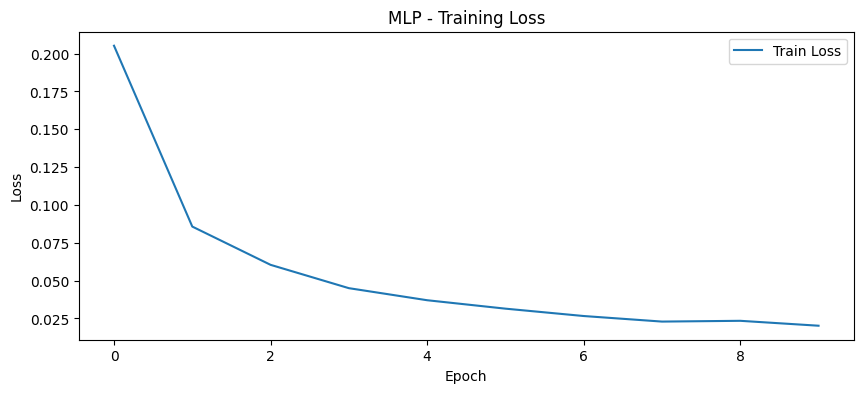

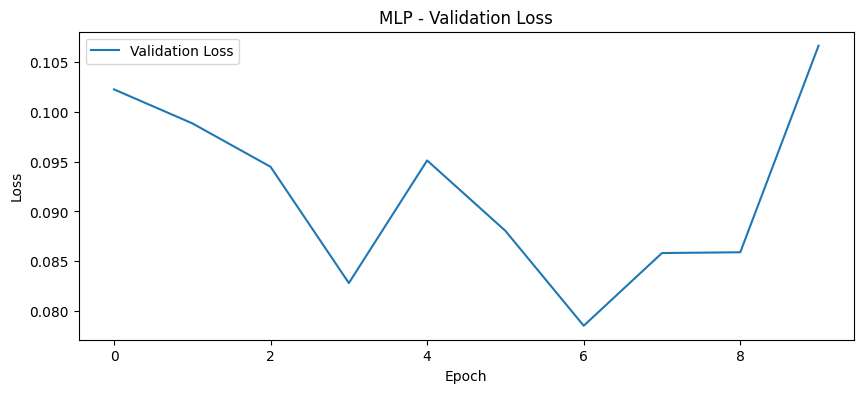

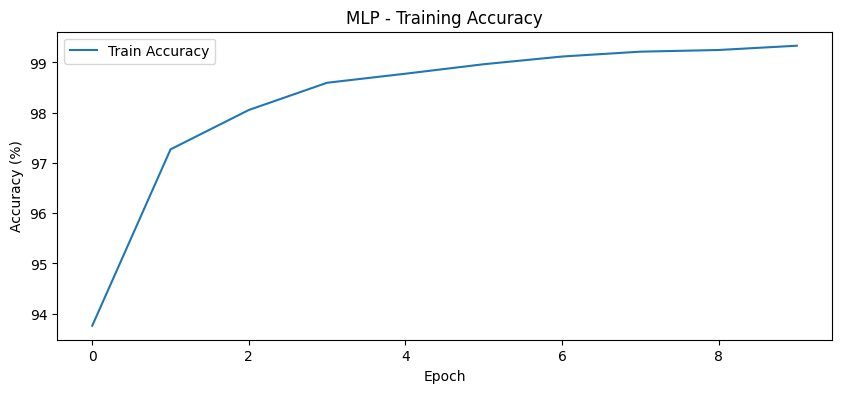

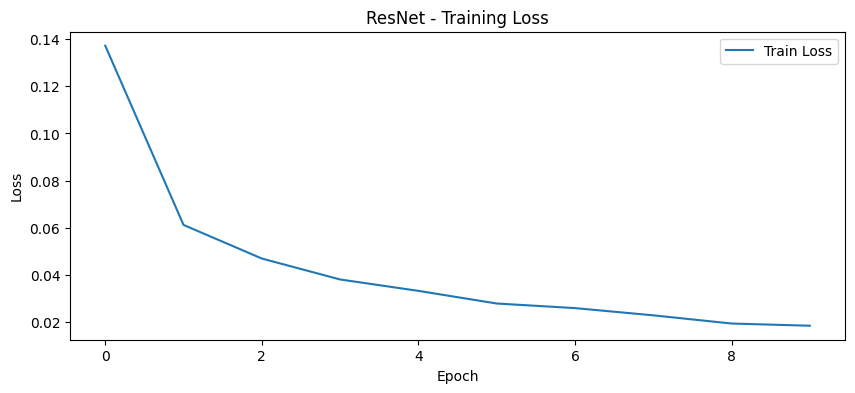

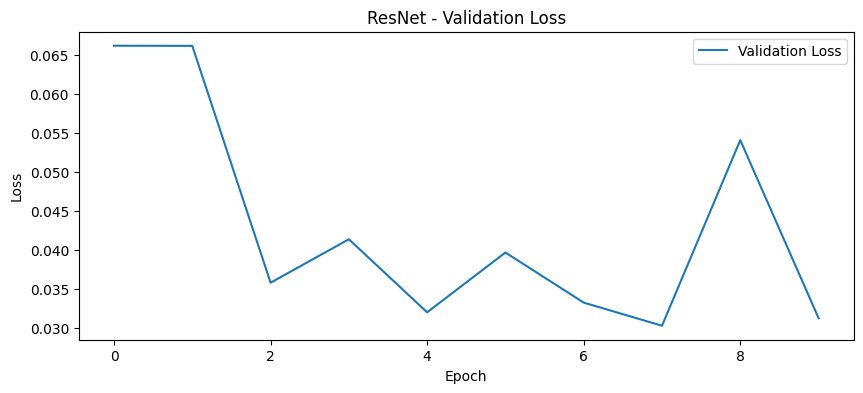

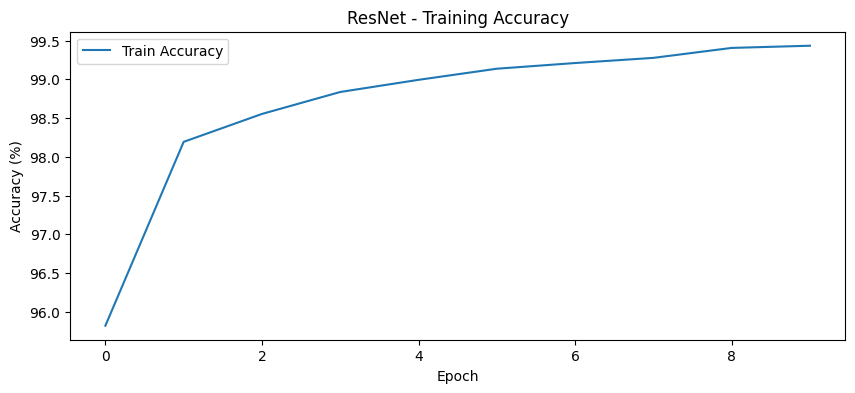

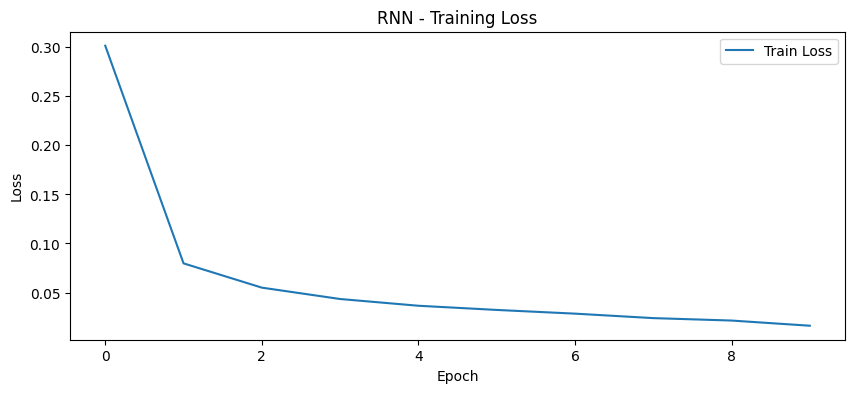

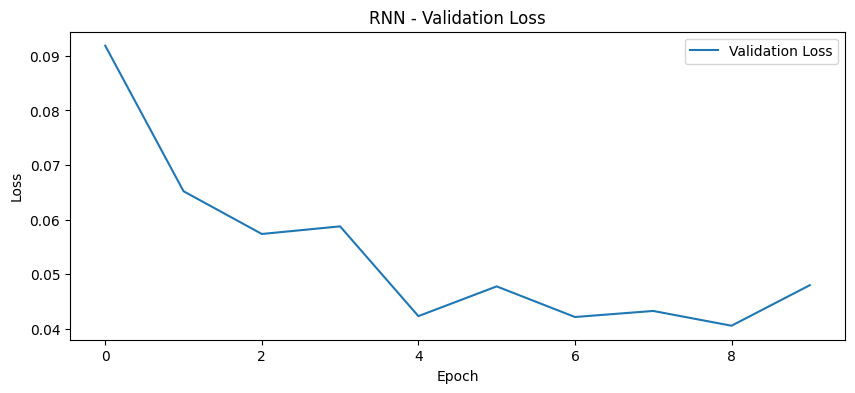

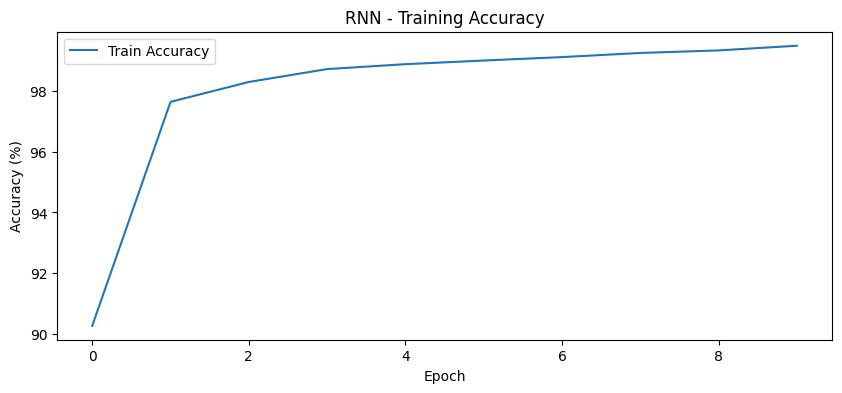

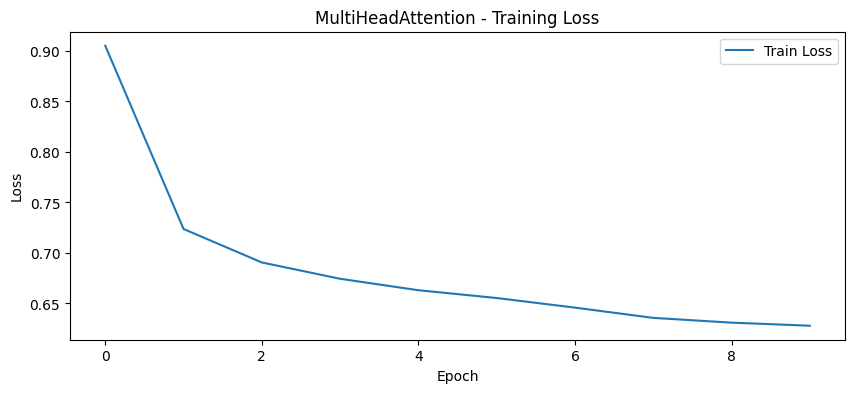

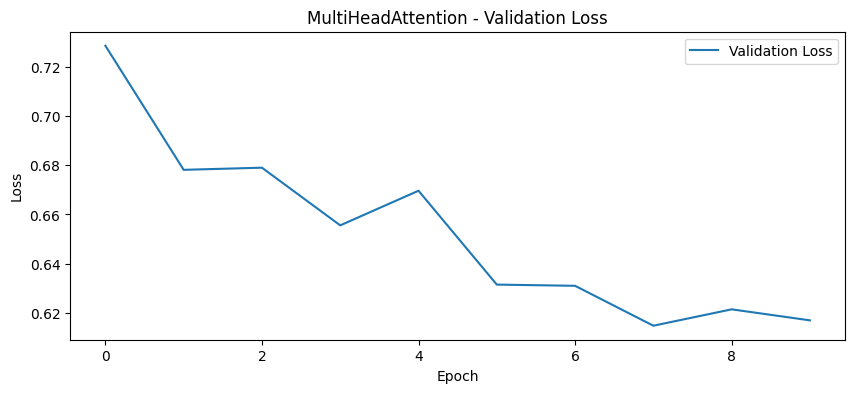

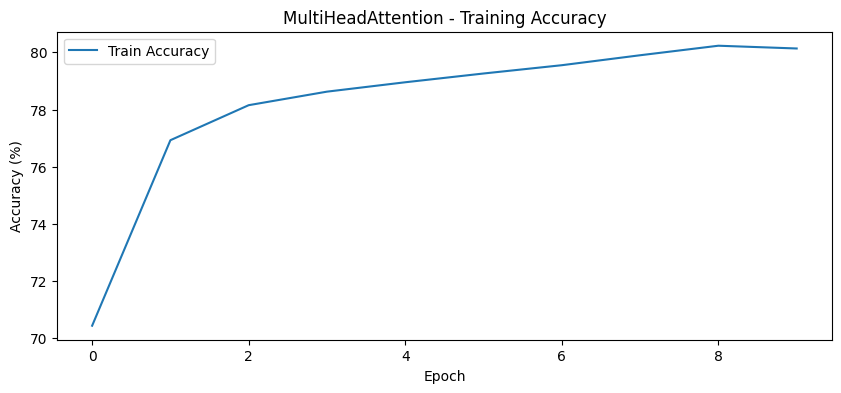

In [12]:
# 用于记录每个模型的训练数据
results = {model_name: {"train_losses": [], "val_losses": [], "train_accs": []} for model_name in models.keys()}

# 训练和评估所有模型
for model_name, model in models.items():
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_name}...")

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
        val_loss, _ = evaluate(model, device, test_loader, criterion)

        # 记录数据
        results[model_name]["train_losses"].append(train_loss)
        results[model_name]["val_losses"].append(val_loss)
        results[model_name]["train_accs"].append(train_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
        
        f"Val Loss: {val_loss:.4f}")

# 绘制每个模型的图表
for model_name, result in results.items():
    # 绘制训练集损失图
    plt.figure(figsize=(10, 4))
    plt.plot(result["train_losses"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Training Loss")
    plt.legend()
    plt.show()

    # 绘制验证集损失图
    plt.figure(figsize=(10, 4))
    plt.plot(result["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Validation Loss")
    plt.legend()
    plt.show()

    # 绘制训练集识别准确率图
    plt.figure(figsize=(10, 4))
    plt.plot(result["train_accs"], label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} - Training Accuracy")
    plt.legend()
    plt.show()